# 3.2 线性回归的从零开始实现

In [1]:
# %matplotlib inline是一个魔法函数（Magic Functions）。官方给出的定义是：IPython有一组预先定义好的所谓的魔法函数（Magic Functions），你可以通过命令行的语法形式来访问它们。
# 使用%matplotlib命令可以将matplotlib的图表直接嵌入到Notebook之中，或者使用指定的界面库显示图表，它有一个参数指定matplotlib图表的显示方式。inline表示将图表嵌入到Notebook中

%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.6.0


## 3.2.1 生成数据集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
# 生成feature数据集
features = torch.randn(num_examples,    num_inputs,dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 加入噪声项
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),dtype=torch.float32)

In [3]:
print(features[0], labels[0])
print(features.shape)

tensor([ 1.5523, -0.5275]) tensor(9.1078)
torch.Size([1000, 2])


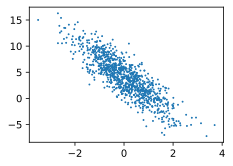

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6191, -1.4160],
        [-1.7160, -0.1224],
        [ 1.9483, -0.6688],
        [ 1.0612, -1.0296],
        [ 0.6497,  0.3901],
        [-0.9467,  1.1579],
        [ 0.8837, -1.1252],
        [-2.2561,  1.1797],
        [-0.2924,  0.3428],
        [ 0.0982, -0.1550]]) 
 tensor([ 7.7725,  1.1808, 10.3656,  9.8001,  4.1816, -1.6356,  9.7840, -4.3188,
         2.4438,  4.9267])


## 3.2.3 初始化模型参数

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [8]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [9]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [10]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [11]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.048063
epoch 2, loss 0.000191
epoch 3, loss 0.000044


In [13]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9992],
        [-3.3993]], requires_grad=True)
4.2 
 tensor([4.1996], requires_grad=True)
